In [21]:
import pandas as pd

In [35]:
#df = pd.read_csv("tmdb_5000_credits.csv")
#df.head(3).to_csv('tmdb_3_credits.csv', index=False, header=True)

In [70]:
import pandas as pd
import networkx as nx
import json

def build_movie_credits_graph(csv_file):
    """
    Build a comprehensive NetworkX graph from TMDB credits data.
    
    Args:
        csv_file: Path to the CSV file containing movie credits
        
    Returns:
        nx.Graph: A graph with movies and people as nodes, relationships as edges
    """
    # Read the CSV file
    df = pd.read_csv(csv_file)
    df = df.iloc[:20, :]
    
    # Create an undirected graph
    G = nx.Graph()
    
    for _, row in df.iterrows():
        movie_id = row['movie_id']
        movie_title = row['title']
        
        # Add movie node with attributes
        G.add_node(f"movie_{movie_id}", 
                   type='movie',
                   title=movie_title,
                   movie_id=movie_id)
        
        # Parse and process cast members
        if pd.notna(row['cast']):
            cast_list = json.loads(row['cast'])
            for cast_member in cast_list:
                person_id = f"person_{cast_member['id']}"
                
                # Add person node if not exists (with minimal attributes)
                if not G.has_node(person_id):
                    G.add_node(person_id,
                               type='person',
                               name=cast_member['name'],
                               person_id=cast_member['id'],
                               gender=cast_member.get('gender', 0))
                
                # Add edge between movie and cast member
                G.add_edge(f"movie_{movie_id}", person_id,
                           relationship='cast',
                           character=cast_member.get('character', ''),
                           order=cast_member.get('order', 999))
        
        # Parse and process crew members
        if pd.notna(row['crew']):
            crew_list = json.loads(row['crew'])
            for crew_member in crew_list:
                person_id = f"person_{crew_member['id']}"
                
                # Add person node if not exists
                if not G.has_node(person_id):
                    G.add_node(person_id,
                               type='person',
                               name=crew_member['name'],
                               person_id=crew_member['id'],
                               gender=crew_member.get('gender', 0))
                
                # Add edge between movie and crew member
                # Note: A person can have multiple crew roles
                edge_key = f"{crew_member.get('department', 'Unknown')}_{crew_member.get('job', 'Unknown')}"
                
                if G.has_edge(f"movie_{movie_id}", person_id):
                    # If edge exists, append to roles list
                    edge_data = G[f"movie_{movie_id}"][person_id]
                    if 'crew_roles' not in edge_data:
                        edge_data['crew_roles'] = []
                    edge_data['crew_roles'].append({
                        'department': crew_member.get('department', ''),
                        'job': crew_member.get('job', '')
                    })
                else:
                    # Create new edge
                    G.add_edge(f"movie_{movie_id}", person_id,
                               relationship='crew',
                               crew_roles=[{
                                   'department': crew_member.get('department', ''),
                                   'job': crew_member.get('job', '')
                               }])
    
    return G


def analyze_graph(G):
    """Print basic statistics about the graph."""
    print(f"Total nodes: {G.number_of_nodes()}")
    print(f"Total edges: {G.number_of_edges()}")
    
    movie_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'movie']
    person_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'person']
    
    print(f"Movie nodes: {len(movie_nodes)}")
    print(f"Person nodes: {len(person_nodes)}")
    
    # Find people who worked on multiple movies
    person_connections = {}
    for person in person_nodes:
        movies = [n for n in G.neighbors(person) if G.nodes[n]['type'] == 'movie']
        if len(movies) > 1:
            person_connections[G.nodes[person]['name']] = len(movies)
    
    if person_connections:
        print("\nPeople in multiple movies:")
        for name, count in sorted(person_connections.items(), key=lambda x: x[1], reverse=True):
            print(f"  {name}: {count} movies")
    
    return movie_nodes, person_nodes


# Example usage
if __name__ == "__main__":
    # Build the graph
    G = build_movie_credits_graph('tmdb_5000_credits.csv')
    
    ## Analyze it
    #print("Graph Analysis")
    #print("=" * 50)
    #movie_nodes, person_nodes = analyze_graph(G)
    
    ## Example: Get all cast members of the first movie
    #first_movie = movie_nodes[0]
    #print(f"\n\nCast of '{G.nodes[first_movie]['title']}':")
    #for neighbor in G.neighbors(first_movie):
    #    edge_data = G[first_movie][neighbor]
    #    if edge_data.get('relationship') == 'cast':
    #        person_name = G.nodes[neighbor]['name']
    #        character = edge_data.get('character', 'Unknown')
    #        print(f"  {person_name} as {character}")
    
    # Example: Export to different formats
    # nx.write_gexf(G, 'movie_graph.gexf')  # For Gephi
    # nx.write_gml(G, 'movie_graph.gml')  # For general use

In [71]:
print(G)

Graph with 2475 nodes and 2745 edges


In [72]:
# https://www.themoviedb.org/
example_name = "movie_TMDB"

# Create graph using `turingdb` python package

<div class="alert alert-block alert-info">
    <h2>
        See <a href="https://docs.turingdb.ai/quickstart">TuringDB Get started documentation</a> for the important steps to follow :
    </h2>
    <h3>
        <ul>
            <li>Create your TuringDB account</li>
            <li>Create your instance in the <a href="https://console.turingdb.ai/auth">TuringDB Cloud UI</a></li>
            <li>Copy your Instance ID from the Database Instances management page</li>
            <li>Get API Key from the Settings in UI</li>
        </ul>
        Remember to have your instance active while working in this notebook !
    </h3>
</div>

In [73]:
from turingdb import TuringDB

# Create TuringDB client
client = TuringDB(
    host="http://localhost:6666"  # Remove this parameter and set the two parameters below
    # instance_id="...",  # Replace by your instance id
    # auth_token="...",  # Replace by your API token
)

In [74]:
# Get list of available graphs
list_graphs = client.query("LIST GRAPH").loc[:, 0].tolist()

In [75]:
# Set graph name
graph_name_prefix = example_name
graph_name_nb_suffix = str(
    max(
        [
            int(re.sub(graph_name_prefix, "", g))
            for g in list_graphs
            if g.startswith(graph_name_prefix)
            and re.sub(graph_name_prefix, "", g).isdigit()
        ]
        + [0]
    )
    + 1
)
graph_name = graph_name_prefix + graph_name_nb_suffix
graph_name = re.sub("-", "_", graph_name)
graph_name

'movie_TMDB4'

In [76]:
%%time

# Create a new graph
client.query(f"CREATE GRAPH {graph_name}")
client.set_graph(graph_name)

# Create a new change on the graph
change = client.query("CHANGE NEW").loc[0, 0]

# Checkout into the change
client.checkout(change=change)

CPU times: user 2.12 ms, sys: 3.89 ms, total: 6.01 ms
Wall time: 4.6 ms


In [77]:
# Build CREATE command from networkx object
create_command = build_create_command_from_networkx(G)
print(f"Cypher CREATE command :\n\n{100 * '*'}\n{create_command}\n{100 * '*'}")

Cypher CREATE command :

****************************************************************************************************
CREATE (n0:Movie {"id":"movie_19995", "type":"movie", "title":"Avatar", "movie_id":"19995"}),
(n1:Person {"id":"person_65731", "type":"person", "name":"Sam Worthington", "person_id":"65731", "gender":"2"}),
(n2:Person {"id":"person_8691", "type":"person", "name":"Zoe Saldana", "person_id":"8691", "gender":"1"}),
(n3:Person {"id":"person_10205", "type":"person", "name":"Sigourney Weaver", "person_id":"10205", "gender":"1"}),
(n4:Person {"id":"person_32747", "type":"person", "name":"Stephen Lang", "person_id":"32747", "gender":"2"}),
(n5:Person {"id":"person_17647", "type":"person", "name":"Michelle Rodriguez", "person_id":"17647", "gender":"1"}),
(n6:Person {"id":"person_1771", "type":"person", "name":"Giovanni Ribisi", "person_id":"1771", "gender":"2"}),
(n7:Person {"id":"person_59231", "type":"person", "name":"Joel David Moore", "person_id":"59231", "gender":"2

In [27]:
with open(f"{example_name}_create_command.txt", "w") as f:
    f.write(create_command)

In [78]:
%%time

# Run CREATE command
client.query(create_command)

# Commit the change
client.query("COMMIT")
client.query("CHANGE SUBMIT")

# Checkout into main
client.checkout()

CPU times: user 3.6 ms, sys: 2.98 ms, total: 6.58 ms
Wall time: 125 ms


<div class="alert alert-block alert-info">
    <h2>
        Visualize your graph in TuringDB Graph Visualizer ! Now that your instance is running:
    </h2>
    <h3>
        <ul>
            <li>Go to <a href="https://console.turingdb.ai/databases">TuringDB Console - Database Instances</a></li>
            <li>In your current instance panel, click on "Open Visualizer" button</li>
            <li>Visualizer opens, now you can choose your graph in the dropdown menu at the top-right corner</li>
        </ul>
        You can then play with your graph and visualize the nodes you want !
    </h3>
</div>

In [79]:
with open(f"{example_name}_CREATE_command.cypher", "w") as f:
    f.write(create_command)

# Roget's Thesaurus

Loaded roget_dat.txt containing 1022 categories.
DiGraph with 1022 nodes and 5075 edges
21 connected components


skipping self loop 400 400


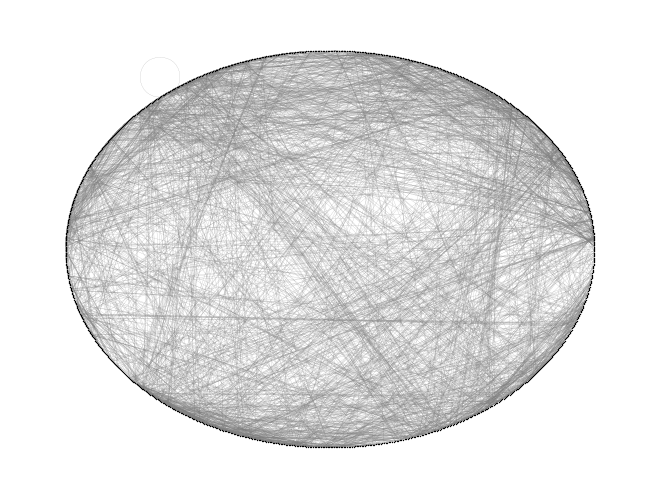

In [4]:
import gzip
import re
import sys

import matplotlib.pyplot as plt
import networkx as nx


def roget_graph():
    """Return the thesaurus graph from the roget.dat example in
    the Stanford Graph Base.
    """
    # open file roget_dat.txt.gz
    fh = gzip.open("roget_dat.txt.gz", "r")

    G = nx.DiGraph()

    for line in fh.readlines():
        line = line.decode()
        if line.startswith("*"):  # skip comments
            continue
        if line.startswith(" "):  # this is a continuation line, append
            line = oldline + line
        if line.endswith("\\\n"):  # continuation line, buffer, goto next
            oldline = line.strip("\\\n")
            continue

        (headname, tails) = line.split(":")

        # head
        numfind = re.compile(r"^\d+")  # re to find the number of this word
        head = numfind.findall(headname)[0]  # get the number

        G.add_node(head)

        for tail in tails.split():
            if head == tail:
                print("skipping self loop", head, tail, file=sys.stderr)
            G.add_edge(head, tail)

    return G


G = roget_graph()
print("Loaded roget_dat.txt containing 1022 categories.")
print(G)
UG = G.to_undirected()
print(nx.number_connected_components(UG), "connected components")

options = {
    "node_color": "black",
    "node_size": 1,
    "edge_color": "gray",
    "linewidths": 0,
    "width": 0.1,
}
nx.draw_circular(UG, **options)
plt.show()

In [5]:
example_name = "rogets_thesaurus"

In [14]:
%load_ext autoreload
%autoreload 2

from turingdb_examples.graph import (
    build_create_command_from_networkx,
)

In [15]:
for node in list(G.nodes(data=True))[:10]:
    print(node)

('1', {})
('2', {})
('69', {})
('125', {})
('149', {})
('156', {})
('166', {})
('193', {})
('455', {})
('506', {})


In [16]:
for edge in list(G.edges(data=True))[:10]:
    print(edge)

('1', '2', {})
('1', '69', {})
('1', '125', {})
('1', '149', {})
('1', '156', {})
('1', '166', {})
('1', '193', {})
('1', '455', {})
('1', '506', {})
('1', '527', {})


# Create graph using `turingdb` python package

<div class="alert alert-block alert-info">
    <h2>
        See <a href="https://docs.turingdb.ai/quickstart">TuringDB Get started documentation</a> for the important steps to follow :
    </h2>
    <h3>
        <ul>
            <li>Create your TuringDB account</li>
            <li>Create your instance in the <a href="https://console.turingdb.ai/auth">TuringDB Cloud UI</a></li>
            <li>Copy your Instance ID from the Database Instances management page</li>
            <li>Get API Key from the Settings in UI</li>
        </ul>
        Remember to have your instance active while working in this notebook !
    </h3>
</div>

In [17]:
from turingdb import TuringDB

# Create TuringDB client
client = TuringDB(
    host="http://localhost:6666"  # Remove this parameter and set the two parameters below
    # instance_id="...",  # Replace by your instance id
    # auth_token="...",  # Replace by your API token
)

In [18]:
# Get list of available graphs
list_graphs = client.query("LIST GRAPH").loc[:, 0].tolist()

In [11]:
# Set graph name
graph_name_prefix = example_name
graph_name_nb_suffix = str(
    max(
        [
            int(re.sub(graph_name_prefix, "", g))
            for g in list_graphs
            if g.startswith(graph_name_prefix)
            and re.sub(graph_name_prefix, "", g).isdigit()
        ]
        + [0]
    )
    + 1
)
graph_name = graph_name_prefix + graph_name_nb_suffix
graph_name = re.sub("-", "_", graph_name)
graph_name

'rogets_thesaurus3'

In [23]:
%%time

# Create a new graph
client.query(f"CREATE GRAPH {graph_name}")
client.set_graph(graph_name)

# Create a new change on the graph
change = client.query("CHANGE NEW").loc[0, 0]

# Checkout into the change
client.checkout(change=change)

CPU times: user 5.16 ms, sys: 18 μs, total: 5.18 ms
Wall time: 4.35 ms


In [24]:
# Build CREATE command from networkx object
create_command = build_create_command_from_networkx(G)
print(f"Cypher CREATE command :\n\n{100 * '*'}\n{create_command}\n{100 * '*'}")

node_parts : (n0:Node {"id":"1"})
node_parts : (n1:Node {"id":"2"})
node_parts : (n2:Node {"id":"69"})
node_parts : (n3:Node {"id":"125"})
node_parts : (n4:Node {"id":"149"})
node_parts : (n5:Node {"id":"156"})
node_parts : (n6:Node {"id":"166"})
node_parts : (n7:Node {"id":"193"})
node_parts : (n8:Node {"id":"455"})
node_parts : (n9:Node {"id":"506"})
node_parts : (n10:Node {"id":"527"})
node_parts : (n11:Node {"id":"4"})
node_parts : (n12:Node {"id":"167"})
node_parts : (n13:Node {"id":"192"})
node_parts : (n14:Node {"id":"194"})
node_parts : (n15:Node {"id":"368"})
node_parts : (n16:Node {"id":"458"})
node_parts : (n17:Node {"id":"526"})
node_parts : (n18:Node {"id":"771"})
node_parts : (n19:Node {"id":"3"})
node_parts : (n20:Node {"id":"323"})
node_parts : (n21:Node {"id":"325"})
node_parts : (n22:Node {"id":"34"})
node_parts : (n23:Node {"id":"360"})
node_parts : (n24:Node {"id":"432"})
node_parts : (n25:Node {"id":"452"})
node_parts : (n26:Node {"id":"5"})
node_parts : (n27:Node 

In [25]:
%%time

# Run CREATE command
client.query(create_command)

# Commit the change
client.query("COMMIT")
client.query("CHANGE SUBMIT")

# Checkout into main
client.checkout()

CPU times: user 2.94 ms, sys: 2.89 ms, total: 5.83 ms
Wall time: 45.8 ms


<div class="alert alert-block alert-info">
    <h2>
        Visualize your graph in TuringDB Graph Visualizer ! Now that your instance is running:
    </h2>
    <h3>
        <ul>
            <li>Go to <a href="https://console.turingdb.ai/databases">TuringDB Console - Database Instances</a></li>
            <li>In your current instance panel, click on "Open Visualizer" button</li>
            <li>Visualizer opens, now you can choose your graph in the dropdown menu at the top-right corner</li>
        </ul>
        You can then play with your graph and visualize the nodes you want !
    </h3>
</div>